<a href="https://colab.research.google.com/github/VasylDvorakDS/Transfer_learning_Hugging_Face/blob/master/Transfer_learning_Huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Упрощаем использование TL. Фреймворк Huggingface

## Первый семинар

![image.png](attachment:image.png)

## Второй семинар

![fdbd6488-6edc-4a18-8070-7f587f38bc92.jfif](attachment:fdbd6488-6edc-4a18-8070-7f587f38bc92.jfif)

Вы уже получили представление, с чего начинается проект с нейросетями или откуда брать эмбеддинги.

- Например, вы можете взять Colab и создать поисковик по изображениям: https://blog.roboflow.com/clip-image-search-faiss/.
- Или можете создать рекомендательныю систему по текстовым описаниям товаров: https://www.kaggle.com/code/andrzejpackard/bert-and-faiss-for-recomendation-engine

Следующий шаг – упростить себе работу с широчайшим перечнем предобученных моделей.

Нам понадобится библиотека transformers.

In [1]:
# !pip install transformers

## Почему трансформеры?

- Не простые эмбеддинги, а позиционные (часть слова + положение в последовательности)
- 10-20 одинаковых модулей, которые постоянно рассылают друг другу "запросы"
- Каждый модуль практически равен строчке кода в программе (хотя может делать гораздо более сложные вещи)
- Очень эффективно вычисляется и распараллеливается

В предшествующих (реккурентных) сетях обучение и вычисление велось по цепочке. Тут все параллельно.

* GPT3 учитывал 8000.
* GPT4 учитывает 32000 токенов в качестве контекста (объем маленькой книги).
* Flash attention – 64000 (среднего размера книга)

![image.png](attachment:image.png)

https://www.youtube.com/watch?v=NzLwHcqE6Jw

Зато... трансформеры требуют огромного количества памяти.

* _Stable Diffusion_ – модели от 10 Гб и больше
* _GPT_... давайте посмотрим на сайте

# Что такое Huggingface

* Сотни тысяч предобученных моделей
* Очень много датасетов (как и в kaggle, и в Google Dataset Search)
* HF Spaces

Пройдемся по https://huggingface.co/

Когда нужно хранить модель локально, а когда лучше пользоваться API?

## Примеры кода (pipeline)

Объекты Pipeline: https://huggingface.co/docs/transformers/v4.35.2/en/main_classes/pipelines

Демо чат-бота:

- https://huggingface.co/tasks/conversational
- https://huggingface.co/docs/transformers/v4.35.2/en/main_classes/pipelines#transformers.ConversationalPipeline

```python
from transformers import pipeline, Conversation

chatbot = pipeline(model="microsoft/DialoGPT-medium")
conversation = Conversation("Going to the movies tonight - any suggestions?")
conversation = chatbot(conversation)
conversation.generated_responses[-1]
>>> 'The Big Lebowski'

conversation.add_user_input("Is it an action movie?")
conversation = chatbot(conversation)
conversation.generated_responses[-1]
>>> "It's a comedy."
```

Онлайн-демо: https://huggingface.co/spaces/shawhin/vanilla-chatbot

# Задачи компьютерного зрения

* Оценка карты глубины по фотографии: https://huggingface.co/blog/cv_state#support-for-pipelines
* Классификация изображений
* Сегментация изображений
* Перевод изображения в изображение
* Детекция объектов
* Классификация видео
* Классификация без заранее определенных меток (ZeroShot Classification)

Перечень задач: https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#computer-vision

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<PIL.Image.Image image mode=L size=1280x986 at 0x7E8D8F086B00>


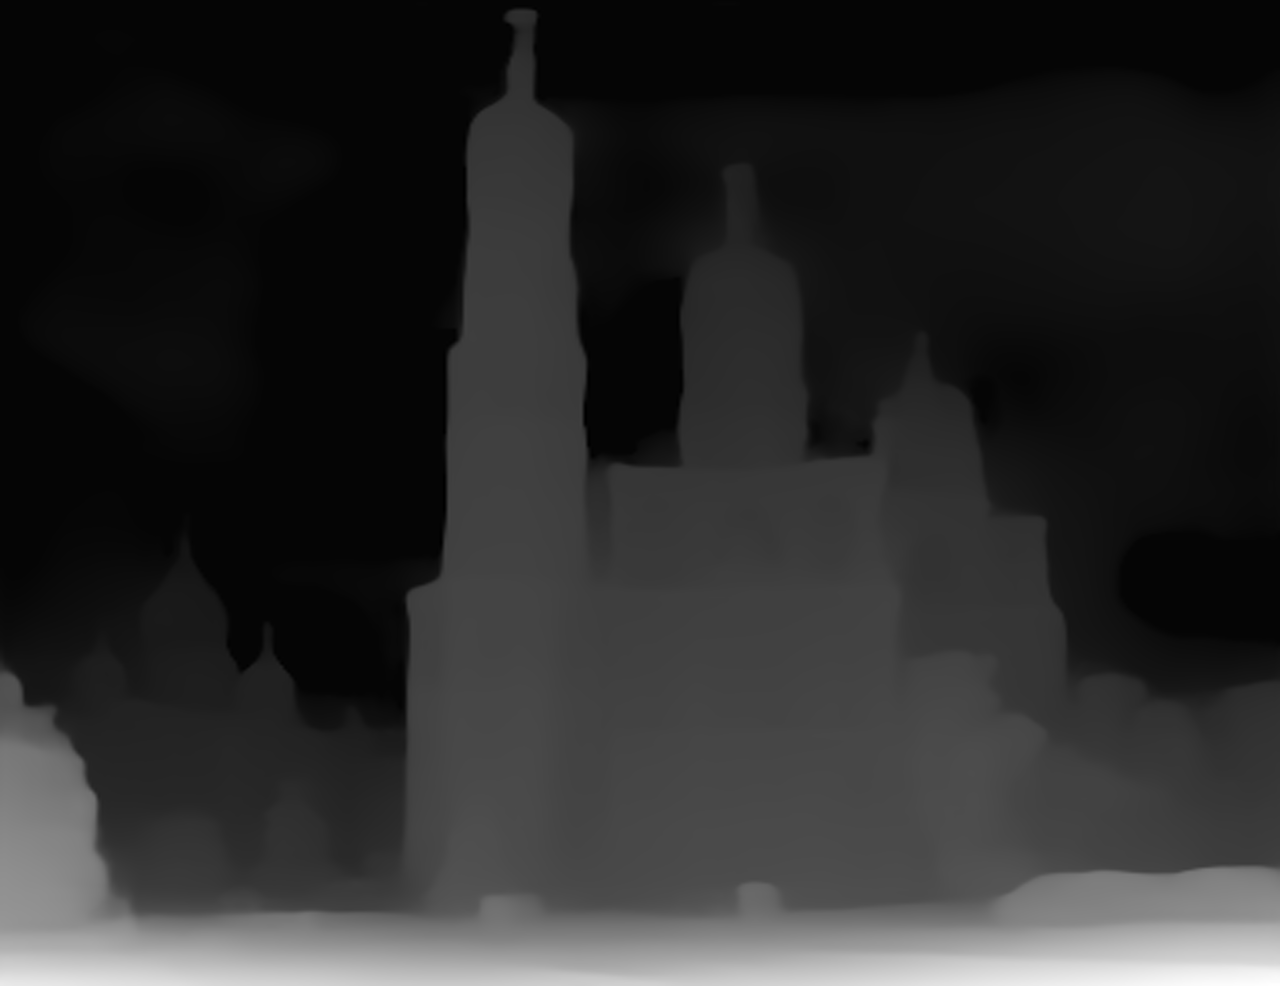

In [19]:
from transformers import pipeline
from PIL import Image
import requests
from io import BytesIO

# Загрузка изображения из URL
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0._%D0%9A%D1%80%D0%B5%D0%BC%D0%BB%D1%8C._%D0%9A%D0%BE%D0%BB%D0%BE%D0%BA%D0%BE%D0%BB%D1%8C%D0%BD%D1%8F_%D0%98%D0%B2%D0%B0%D0%BD%D0%B0_%D0%92%D0%B5%D0%BB%D0%B8%D0%BA%D0%BE%D0%B3%D0%BE_IMG_2111.2_e1b2sm_VIII-2009.jpg/1280px-%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0._%D0%9A%D1%80%D0%B5%D0%BC%D0%BB%D1%8C._%D0%9A%D0%BE%D0%BB%D0%BE%D0%BA%D0%BE%D0%BB%D1%8C%D0%BD%D1%8F_%D0%98%D0%B2%D0%B0%D0%BD%D0%B0_%D0%92%D0%B5%D0%BB%D0%B8%D0%BA%D0%BE%D0%B3%D0%BE_IMG_2111.2_e1b2sm_VIII-2009.jpg"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:133.0) Gecko/20100101 Firefox/133.0" }
response = requests.get(url, headers=headers , timeout=30)
image = Image.open(BytesIO(response.content))

# Создание конвейера для оценки глубины
depth_estimator = pipeline(task="depth-estimation", model="Intel/dpt-large")

# Оценка глубины
output = depth_estimator(image)

# Вывод глубины
print(output["depth"])
# Вызов этой команды возвращает нам тензор, в котором дана оценочная информация
# об удаленности каждого объекта от зрителя (в метрах)
output["depth"]

Генерация изображений там тоже есть, но, как было сказано, диффузионные модели занимают огромное пространство в памяти.

In [22]:
#!pip install diffusers

#from diffusers import DiffusionPipeline
#generator = DiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
#generator.to("cuda")
#image = generator("An image of a squirrel in Picasso style").images[0]

# Поработаем с текстом

Модели, понимающий русский язык: https://huggingface.co/models?language=ru

Например, поищем русские модели для перевода текста в речь: https://huggingface.co/docs/transformers/tasks/text-to-speech

In [14]:
from transformers import pipeline

question_answerer = pipeline(
    "question-answering",
    model="Den4ikAI/rubert-large-squad",
    tokenizer="Den4ikAI/rubert-large-squad"
)

config.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/713M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [8]:
context = """
Во́льфганг Амаде́й Мо́царт (нем. Wolfgang Amadeus Mozart, МФА МФА: [ˈvɔlfɡaŋ amaˈdeus ˈmoːtsaʁt](инф.); полное имя — Иога́нн Хризосто́м Во́льфганг Амаде́й Мо́царт; 27 января 1756, Зальцбург — 5 декабря 1791, Вена) — австрийский композитор и музыкант-виртуоз. Один из самых популярных классических композиторов, Моцарт оказал большое влияние на мировую музыкальную культуру.
По свидетельству современников, Моцарт обладал феноменальным музыкальным слухом, памятью и способностью к импровизации. Самый молодой член[К 1] Болонской филармонической академии (с 1770 года) за всю её историю, а также самый молодой кавалер ордена Золотой шпоры (1770)."""

In [16]:
result = question_answerer(question="Моцарт был кавалером какого ордена?", context=context)
print( result['answer'] )

Золотой шпоры


In [17]:
result

{'score': 0.5918421745300293,
 'start': 624,
 'end': 637,
 'answer': 'Золотой шпоры'}

In [18]:
result = question_answerer(question="Кем был Моцарт?", context=context)
print( result['answer'] )

австрийский композитор и музыкант-виртуоз


# Домашнее задание

Реализуйте классификацию эмоциональной окрашенности текстов при помощи объекта pipeline.

1. Найдите тип задач Sentiment Analysis на huggingface.co
2. Найдите модель для русского языка (примеры: rubert-tiny2..., rubert-base...)

In [33]:
import transformers

classifier = pipeline(task="sentiment-analysis", model="seara/rubert-tiny2-russian-sentiment")


config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Выполните следующую ячейку. Если вы правильно инициализировали `pipeline`, вы получите относительно верные предсказания.

In [34]:
classifier( ["Отличный товар",
            "Мне не понравилось",
            "Прекрасно выглядит, ничего не меняйте!",
            "Ничего не понял",
            "У меня не работала розетка, в остальном все отлично"] )

[{'label': 'positive', 'score': 0.9941100478172302},
 {'label': 'neutral', 'score': 0.5911950469017029},
 {'label': 'positive', 'score': 0.9389205574989319},
 {'label': 'negative', 'score': 0.524005651473999},
 {'label': 'positive', 'score': 0.6734204888343811}]

# Как запустить сервис на основе модели?

Например, в Gradio:

1. https://huggingface.co/spaces/gradio/chatbot
2. https://www.kdnuggets.com/2023/06/build-ai-chatbot-5-minutes-hugging-face-gradio.html

Или в Huggingface Spaces: https://huggingface.co/spaces

# И напоследок поработаем с кодом

In [11]:
from transformers import pipeline

fill_mask = pipeline(
    "fill-mask",
    model="huggingface/CodeBERTa-small-v1",
    tokenizer="huggingface/CodeBERTa-small-v1"
)

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/994k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/483k [00:00<?, ?B/s]

In [12]:
python_code = """
# a list of numbers
my_numbers = [10, 8, 3, 22, 33, 7, 11, 100, 54]
my_numbers.<mask>


"""

In [13]:
fill_mask( python_code )

[{'score': 0.5379529595375061,
  'token': 1942,
  'token_str': 'sort',
  'sequence': '\n# a list of numbers\nmy_numbers = [10, 8, 3, 22, 33, 7, 11, 100, 54]\nmy_numbers.sort\n\n\n'},
 {'score': 0.0820835530757904,
  'token': 3059,
  'token_str': 'clear',
  'sequence': '\n# a list of numbers\nmy_numbers = [10, 8, 3, 22, 33, 7, 11, 100, 54]\nmy_numbers.clear\n\n\n'},
 {'score': 0.05829772353172302,
  'token': 5648,
  'token_str': 'reverse',
  'sequence': '\n# a list of numbers\nmy_numbers = [10, 8, 3, 22, 33, 7, 11, 100, 54]\nmy_numbers.reverse\n\n\n'},
 {'score': 0.02774088643491268,
  'token': 812,
  'token_str': 'append',
  'sequence': '\n# a list of numbers\nmy_numbers = [10, 8, 3, 22, 33, 7, 11, 100, 54]\nmy_numbers.append\n\n\n'},
 {'score': 0.01872047409415245,
  'token': 808,
  'token_str': 'length',
  'sequence': '\n# a list of numbers\nmy_numbers = [10, 8, 3, 22, 33, 7, 11, 100, 54]\nmy_numbers.length\n\n\n'}]

# Библиография

https://colab.research.google.com/github/huggingface/notebooks/blob/master/transformers_doc/task_summary.ipynb#scrollTo=QGwpVScF2kZO

https://huggingface.co/huggingface/CodeBERTa-small-v1

https://huggingface.co/spaces/codeparrot/code-generation-models